In [141]:
import os
HOME = os.path.expanduser('~')
import numpy as np
import rasterio
from rasterio.plot import show
from osgeo import gdal
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
from datetime import datetime, date
import geopandas as gpd
import rioxarray as rxr
from rasterio.plot import plotting_extent
import earthpy.plot as ep
import contextily as cx
from matplotlib.colors import LinearSegmentedColormap, ListedColormap



In [5]:

#Load GeoTiff Dataset
file = f"{HOME}/SWEMLv2.0/data/SnowClassification/SnowClass_NA_300m_10.0arcsec_2021_v01.0.tif" 
dataset = gdal.Open(file, gdal.GA_ReadOnly) 
# Note GetRasterBand() takes band no. starting from 1 not 0
band = dataset.GetRasterBand(1)
arr = band.ReadAsArray()
arr.shape

/home/whitelightning450/mambaforge/envs/SWEML_310/lib/python3.10/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


(32400, 61200)

In [6]:
width = dataset.RasterXSize
height = dataset.RasterYSize
gt = dataset.GetGeoTransform()

print(width, height, gt)

61200 32400 (-180.0, 0.002777777777777778, 0.0, 90.0, 0.0, -0.002777777777777778)


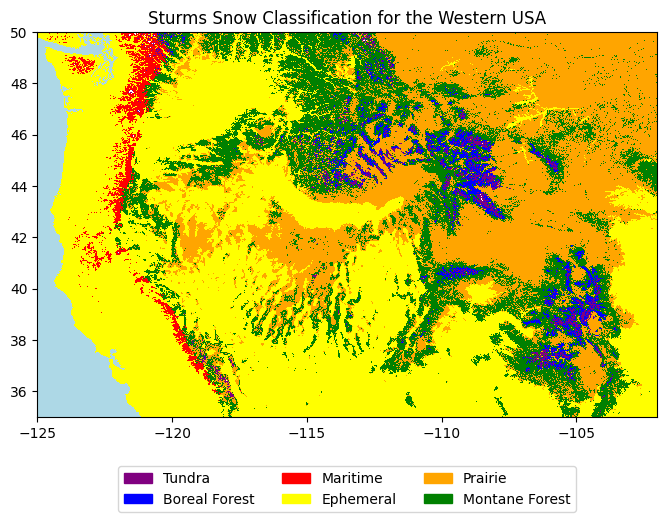

In [ ]:

clipped = arr[14800:19500, 19800:27500]

cmap = ListedColormap(['purple', 'blue', 'red', 'yellow', 'orange', 'green', 'white','lightblue'])
labels =['Tundra', 'Boreal Forest', 'Maritime', 'Ephemeral', 'Prairie', 'Montane Forest']

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
plt.title('Sturms Snow Classification for the Western USA')
norm = plt.Normalize(vmin=clipped.min(), vmax=clipped.max())
#cmap = plt.get_cmap('Paired')

plt.imshow(clipped, 
           cmap=cmap,
           interpolation='none',
           #norm=norm,
           extent = [-125,-102,35,50],
           aspect = 'auto'
           )
handles = [plt.Rectangle((0, 0), 0, 0, color=cmap(i), label=labels[i]) for i in np.arange(0,6,1)]
ax.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -.265),
          ncol=3, fancybox=True)
plt.savefig('Figures/SturmsWUS.png', dpi=600, bbox_inches="tight")

# make figures of each unique area(s) for input and predictions.

In [ ]:
# Make figure of ASO locations, show elevation profiles
region = 'Northwest'
output_res = '300M_Resolution'
DataFrame = 'Vegetation_Sturm_Seasonality_PrecipVIIRSGeoObsDFs'
fSCA_thresh = '20_fSCA_Thresh'
markersize = 0.5
cmap= 'terrain'
Title = 'ASO regions in the Pacific NW Mountains'
variant = 'World_Imagery'
figname = 'PacificNWASO'


 #Get training data 
filepath = f"{HOME}/SWEMLv2.0/data/TrainingDFs/{region}/{output_res}/{DataFrame}/{fSCA_thresh}"
#try:
files = [filename for filename in os.listdir(filepath) if filename.endswith(".parquet")]
print(f'Concatenating {len(files)} for the model dataframe development.')
df = pd.DataFrame()
for file in tqdm_notebook(files):
    datedf = pd.read_parquet(f"{filepath}/{file}")
    df = pd.concat([df,datedf])

#reset index for below steps
df.sort_values('Date', inplace = True)
df.reset_index(inplace=True)

#get unique locations - drop duplicates
df.drop_duplicates(subset='cell_id', keep="last", inplace=True)

#convert to geopandas to plot spatially
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.cen_lon, df.cen_lat), crs=4326)

#Make Figure
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

gdf.plot(column='Elevation_m',
                ax = ax,
                legend=True,
                markersize=markersize,
                marker = 's',
                legend_kwds={"label": "Elevation (m)", "orientation": "vertical"},
                cmap = cmap,
                # interpolation='none',
                # extent = [-125,-110,35,40],
                # aspect = 'auto'
                    )
ax.set_xlim(-125, -121)
ax.set_ylim(47, 49)
cx.add_basemap(ax, 
               source="https://server.arcgisonline.com/ArcGIS/rest/services/"+variant+"/MapServer/tile/{z}/{y}/{x}", 
               crs=gdf.crs)   #cx.providers.OpenStreetMap.Mapnik)
#ax.set_axis_off()
plt.title(Title)
plt.savefig(f"./Figures/{figname}.png", dpi =600, bbox_inches='tight')
plt.show()


Concatenating 2 for the model dataframe development.


/tmp/ipykernel_915/3911975751.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm_notebook(files):


  0%|          | 0/2 [00:00<?, ?it/s]

In [159]:
gdf.columns

Index(['cell_id', 'Date', 'cen_lat', 'cen_lon', 'Elevation_m', 'Slope_Deg',
       'Aspect_Deg', 'swe_m', 'ns_1', 'ns_2', 'ns_3', 'ns_4', 'ns_5', 'ns_6',
       'VIIRS_SCA', 'hasSnow', 'season_precip_cm', 'DOS', 'WY_week',
       'ns_1_week_mean', 'ns_2_week_mean', 'ns_3_week_mean', 'ns_4_week_mean',
       'ns_5_week_mean', 'ns_6_week_mean', 'Seasonal_ns_1_rel',
       'Seasonal_ns_2_rel', 'Seasonal_ns_3_rel', 'Seasonal_ns_4_rel',
       'Seasonal_ns_5_rel', 'Seasonal_ns_6_rel', 'sturm_value',
       'vegetation_value', 'geometry', 'ASO_swe_cm'],
      dtype='object')

In [ ]:
d

# Make figures showing MOdel inputs and targets

In [202]:
def spatial_figs(region, output_res, DataFrame, fSCA_thresh, var, var_axis_label, varname, varshort, reg, cmap, markersize, obs, swe, f, watershed, plot,zoom):

    #Get training data 
    filepath = f"{HOME}/SWEMLv2.0/data/TrainingDFs/{region}/{output_res}/{DataFrame}/{fSCA_thresh}"
    #try:
    files = [filename for filename in os.listdir(filepath) if filename.endswith(".parquet")]
    files.sort()
    print(f'Concatenating {len(files)} for the model dataframe development.')
    df = pd.DataFrame()

    df = pd.read_parquet(f"{filepath}/{files[f]}")

    #reset index for below steps
    df.sort_values('Date', inplace = True)


    #convert to geopandas to plot spatially
    gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.cen_lon, df.cen_lat), crs=4326)

    #get swe in cm
    gdf['ASO_swe_cm'] = gdf['swe_m']*100
    gdf['season_precip_cm'] = gdf['season_precip_cm']*2.54
    if var == 'Aspect_Deg':
        gdf['Aspect_Deg'] = gdf['Aspect_Deg']-270
        df = gdf[gdf['Aspect_Deg']>= 0]
        df['Aspect_Deg'] = abs(df['Aspect_Deg']-90)+270
        gdf.update(df)
        gdf['Aspect_Deg'] = abs(gdf['Aspect_Deg'])

    if swe == True:
        gdf =  gdf[gdf['ASO_swe_cm']> 1]

    gdf.reset_index(inplace=True)

    print('Dataframe processed, making figure')

    #Make Figure
    date= str(gdf['Date'][0])[:-9]
    if obs == True:
        Title = f"{varname} \n {watershed} River Basin, {reg} {date}"
    else:
        Title = f"{varname} \n {watershed} River Basin, {reg}"

    variant = 'World_Imagery'
    figname = f"{f}{reg}_{varshort}_{watershed}_zoom={zoom}_{date}"
    minx, miny, maxx, maxy = gdf.geometry.total_bounds

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    gdf.plot(column=var,
                    ax = ax,
                    legend=True,
                    markersize=markersize,
                    marker = 's',
                    legend_kwds={"label": var_axis_label, "orientation": "vertical"},
                    cmap = cmap
                        )

    if zoom == 'out':
        ax.set_xlim(minx*1.01, maxx*.99)
        ax.set_ylim(miny*.99, maxy*1.01)

    if zoom == 'in':
        ax.set_xlim(minx*1.001, maxx*.999)
        ax.set_ylim(miny*.998, maxy*1.002)
    cx.add_basemap(ax, 
                source="https://server.arcgisonline.com/ArcGIS/rest/services/"+variant+"/MapServer/tile/{z}/{y}/{x}", 
                crs=gdf.crs)   #cx.providers.OpenStreetMap.Mapnik)
    #ax.set_axis_off()
    plt.title(Title)
    if plot == True:
        plt.savefig(f"./Figures/{figname}.png", dpi =600, bbox_inches='tight')
    plt.show()


Concatenating 14 for the model dataframe development.
Dataframe processed, making figure


/home/whitelightning450/mambaforge/envs/SWEML_310/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


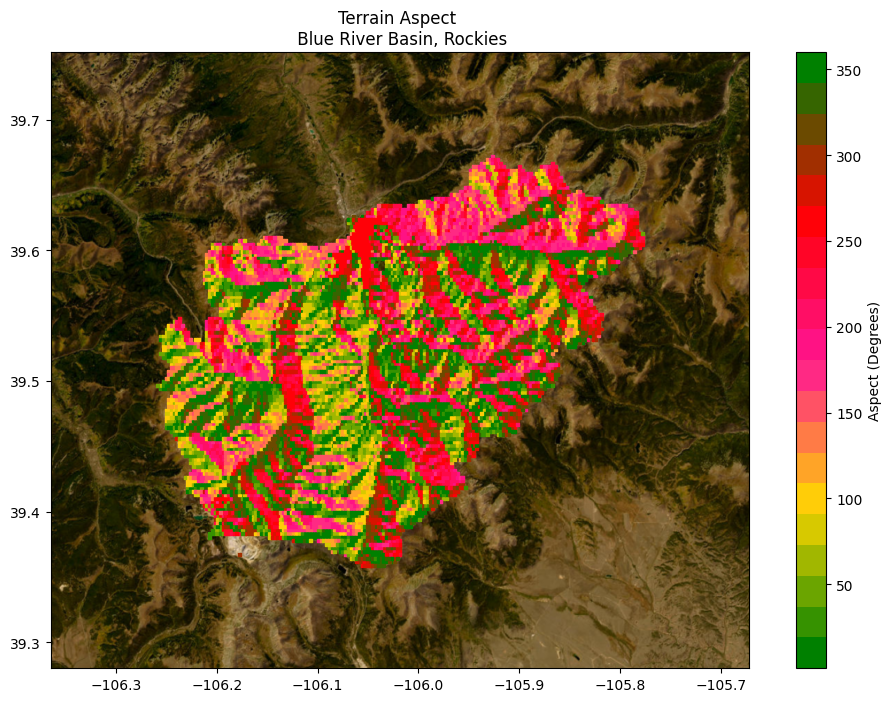

In [215]:
# Make figure of ASO locations, show elevation profiles
region = 'SouthernRockies'
output_res = '300M_Resolution'
DataFrame = 'Vegetation_Sturm_Seasonality_PrecipVIIRSGeoObsDFs'
fSCA_thresh = '20_fSCA_Thresh'
var =  'Aspect_Deg'
var_axis_label = "Aspect (Degrees)"
varname = 'Terrain Aspect'
varshort = 'Aspect'
reg = "Rockies"
#cmap= 'cool'
#cmap = 'terrain'
#cmap = ListedColormap(['purple', 'blue', 'red', 'white', 'yellow', 'orange', 'orange','green'])
colors = ['green', 'gold', 'deeppink', 'red' ,'green'] # first color is black, last is red
cmap = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
#cmap = 'hsv'
markersize = 4
obs = False
swe = False


f = 10# which file to select
watershed = 'Blue'
plot = True
zoom = 'in'


spatial_figs(region, output_res, DataFrame, fSCA_thresh, var, var_axis_label, varname, varshort, reg, cmap, markersize, obs, swe, f, watershed, plot,zoom)


In [ ]:
N = 270 -270
E = 180-270
S = 90 -270
W=0 -270
WNW = 359-270=abs(89-90)+270 

# note, remove 2019-04-07 from model training, looks like bad data, too big, >400 cm
Multiply precip by 2.54 to get cm, looks like its in inches
2018-04-22, 2018-03-04, San Joaquin, seems too big for peaks
add in aspect calculation to DF, might help

In [36]:
files.sort()

In [37]:
files

['Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20130403.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20130429.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20130503.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20130525.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20130601.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20130608.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20140320.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20140323.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20140324.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20140406.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20140407.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20140414.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20140420.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20140423.parquet',
 'Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20140428.parqu

In [ ]:
import pandas as pd
import os
import pandas as pd
import numpy as np
import geopandas as gpd
HOME = os.path.expanduser('~')

region = 'SouthernRockies'
output_directory = f"{HOME}/SWEMLv2.0/data/TrainingDFs/{region}/300M_Resolution/Vegetation_Sturm_Seasonality_PrecipVIIRSGeoObsDFs/20_fSCA_Thresh"


df = pd.read_parquet(f"{output_directory}/Vegetation_Sturm_Season_Precip_VIIRS_GeoObsDF_20190408.parquet")

GeoDF = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.cen_lon, df.cen_lat), crs='EPSG:4326')

GeoDF.head()

In [ ]:
GeoDF.plot('vegetation_value', markersize = 1)